<a href="https://colab.research.google.com/github/nandwanatarun/EVA-DeepLearning/blob/Session-15/S15_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Assignment - 15

Usage of eager execution and TFRecord in Implementing DavidNet

Additionally, input pipeline optimization is carried out to improve on performance.


In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

!nvidia-smi

Mon Dec 16 12:45:56 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

if IN_COLAB: 
    %tensorflow_version 1.x

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Enabling Eager Execution

In [0]:
tf.enable_eager_execution()

Hyperparameters

In [0]:


BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}




Parameter Initialization Like PyTorch

Initialization function now returns a NumPy array for eager execution.


In [0]:


def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype).numpy()




Model

All models are activated with dynamic=True in the super() class ensuring the model has been enabled for eager execution


In [0]:
class ConvBN(tf.keras.Model):
    def __init__(self, c_out):
        super(ConvBN, self).__init__(dynamic=True)
        self.lcount = 1
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", 
                                           kernel_initializer=init_pytorch, use_bias=False, dynamic=True, 
                                           name="Conv2D_"+str(self.lcount))
        self.lcount+=1
        self.bn   = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, dynamic=True, 
                                                      name="BatchNormalization_"+str(self.lcount))

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super(ResBlk, self).__init__(dynamic=True)
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h  

In [0]:
class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super(DavidNet, self).__init__(dynamic=True)
        pool = tf.keras.layers.MaxPooling2D(dynamic=True)
        self.init_conv_bn = ConvBN(c)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ResBlk(c*4, pool)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D(dynamic=True)
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False, dynamic=True)
        self.weight = weight

    def call(self, x, y):
        h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        outval = tf.argmax(h, axis = 1)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(outval, y), tf.float32))
        return loss, correct.numpy(), outval.numpy()


TF Record Dataset

    Build a dataset builder and download from the TensorFlow repository and not Keras (idea is to work on files instead of loaded memory as ndarray)
    Load the CIFAR-10 data from the NFRecord files separating test and train set
    Read each record as tuple of image and label Tensors
    Add normalization, padding and data augmentation methods in the Tensor format to ensure they can be computed on demand
    Add batching and prefetch for subsequent iteration and data read

Till actual iteration begins data is not accessible or loaded (other than prefetched data). Hence, all the computation is carried out in the delayed execution mode.
Input Pipelining

The input to the model are pipelined and parallelized by letting TensorFlow autotune the parameters.

The Ryzen-5 processor with 6 cores and 12 threads are available to parallelize the input reads.


In [9]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tensorflow_datasets as tfds
import tensorflow.contrib.image as tfi

from tensorflow.data import  TFRecordDataset
from glob import glob
from tensorflow_datasets.core import DatasetBuilder

import os

tf.enable_eager_execution()
assert tf.executing_eagerly()

train_mean = (0.4914, 0.4822, 0.4465)
train_std  = (0.2023, 0.1994, 0.2010)
normalize = lambda x: (tf.cast(x, tf.float32)/255 - train_mean) / train_std

random_crop = lambda x,n: tf.random_crop(x, [n, n, 3])
random_flip_left_right = lambda x: tf.image.random_flip_left_right(x)
pad = lambda x, n: tf.pad(x, [[n, n], [n, n], [0, 0]], mode='reflect')
random_rotate = lambda x, n: tf.contrib.image.rotate(x, (np.random.rand()-0.5)*math.pi/180*n)
def cutout(x, si, sj):
    ci = tf.random.uniform((1,), 0, x.shape[0] - si - 1, dtype=tf.int32)[0]
    cj = tf.random.uniform((1,), 0, x.shape[1] - sj - 1, dtype=tf.int32)[0]
    idx = [tf.range(ci, si), tf.range(cj, sj)]
    val = tf.zeros((si, sj, 3))
    tf.tensor_scatter_update(x, idx, val)
    return x
image_augment = lambda x: cutout(normalize(random_rotate(random_crop(random_flip_left_right(pad(x, 4)), 32), 10)), 8, 8)

def parse_fn(example):
    example_fmt = {
        'image': tf.io.FixedLenFeature((), tf.string, ""),
        'label': tf.io.FixedLenFeature((), tf.int64, -1)
    }
    parsed = tf.parse_example(example, example_fmt)
    images = tf.map_fn(tf.io.decode_image, parsed['image'], dtype=tf.uint8)
    images = tf.reshape(images, [-1, 32, 32, 3])
    return (images, parsed['label'])

def make_dataset(path, transform, nfile, dtype=tf.float32, batch=BATCH_SIZE, shuffle=False):
    files = tf.data.Dataset.list_files(path)
    dataset = files.interleave(tf.data.TFRecordDataset, cycle_length=nfile, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch)
    if shuffle:
        dataset = dataset.shuffle(batch)
    func = lambda x: (tf.map_fn(transform, x[0], dtype=dtype), x[1])    
    dataset = dataset.map(map_func=lambda a: func(parse_fn(a)), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

cifar10_bldr = tfds.builder("cifar10")
cifar10_bldr.download_and_prepare()
cifar10_info = cifar10_bldr.info
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

name = cifar10_info.name
vrsn = '{}'.format(cifar10_info.version)

len_train, len_test = cifar10_info.splits['train'].num_examples, cifar10_info.splits['test'].num_examples

cifar10_bldr.download_and_prepare()

train_path = os.path.join(os.getenv("HOME"), 'tensorflow_datasets', name, vrsn, '*train.tfrecord*')
test_path  = os.path.join(os.getenv("HOME"), 'tensorflow_datasets', name, vrsn, '*test.tfrecord*')

train_fn = glob(train_path)
test_fn  = glob(test_path)

train_tfr, test_tfr = make_dataset(train_fn, image_augment, 10), make_dataset(test_fn, normalize, 1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.




Model Initialization

Models is initialized with global step initialized so that the lr_schedule can be configured on the global step. Global step though is a Tensor is returned as an integer as part of eager execution.


In [0]:
model = DavidNet()

assert model.run_eagerly, "Eager execution is not enabled for the model"

batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step.numpy()/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)


Training

The fit or fit_generator calls are not used for training.

    GradientTape records the forward pass gradient computations
    In the back propagation step the recorded values are used to update the trainable parameters.

Final data is printed in a formatted output. TQDM module provides a nice progress bar indication.

Introduction of the TFRecord has increased the total time of training. With parallelization introduced the values can be reduced later.

Single threaded input

Accuracy: 92.93%

Time: 1064.7s

With input pipeline optimization with weights backup

Accuracy: 92.69%

Time: 731.1s


In [11]:
from tensorflow.python.eager.profiler import Profiler, start, stop, save
import os

t = time.time()

try:
    start()
    test_set  = test_tfr.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    train_set = train_tfr.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    max_acc = 0.0
    for epoch in range(EPOCHS):
        train_loss = test_loss = train_acc = test_acc = 0.0
        tf.keras.backend.set_learning_phase(1)
        for (x, y) in tqdm(train_set):
            with tf.GradientTape() as tape:
                loss, correct, _ = model(x, y)

            var = model.trainable_variables
            grads = tape.gradient(loss, var)
            for g, v in zip(grads, var):
                g += v * WEIGHT_DECAY * BATCH_SIZE
            opt.apply_gradients(zip(grads, var), global_step=global_step)

            train_loss += loss.numpy()
            train_acc += correct

        tf.keras.backend.set_learning_phase(0)
        for (x, y) in test_set:
            loss, correct, _ = model(x, y)
            test_loss += loss.numpy()
            test_acc += correct

        train_loss /= len_train
        train_acc  /= len_train
        test_loss  /= len_test
        test_acc   /= len_test

        print('epoch:', epoch+1, 
              'lr:{0:.4f}'.format(lr_schedule(epoch+1)), 
              'train loss: {0:.4f}'.format(train_loss), 
              'train acc: {0:.4f}'.format(train_acc), 
              'val loss: {0:.4f}'.format(test_loss), 
              'val acc: {0:.4f}'.format(test_acc), 
              'time:{0:5.1f}'.format(time.time() - t))

        if test_acc > max_acc:
            max_acc = test_acc
            model_path = 'weights.{0:.4f}-{1:03d}.h5'.format(test_acc, epoch)
            print("Writing model path: ", model_path)
            model.save_weights(model_path)

        if epoch == 10:
            profile_res = stop()
            save('logs', profile_res)

except Exception as e: 
    print(e)
    stop()


epoch: 1 lr:0.0800 train loss: 1.5652 train acc: 0.4355 val loss: 1.1499 val acc: 0.5836 time: 74.5
Writing model path:  weights.0.5836-000.h5



epoch: 2 lr:0.1600 train loss: 0.8462 train acc: 0.7006 val loss: 1.0298 val acc: 0.6588 time:136.8
Writing model path:  weights.0.6588-001.h5



epoch: 3 lr:0.2400 train loss: 0.6499 train acc: 0.7726 val loss: 0.9051 val acc: 0.7003 time:199.3
Writing model path:  weights.0.7003-002.h5



epoch: 4 lr:0.3200 train loss: 0.5572 train acc: 0.8073 val loss: 0.6598 val acc: 0.7759 time:261.6
Writing model path:  weights.0.7759-003.h5



epoch: 5 lr:0.4000 train loss: 0.4929 train acc: 0.8296 val loss: 0.6703 val acc: 0.7815 time:324.1
Writing model path:  weights.0.7815-004.h5



epoch: 6 lr:0.3789 train loss: 0.4076 train acc: 0.8601 val loss: 0.5271 val acc: 0.8211 time:386.4
Writing model path:  weights.0.8211-005.h5



epoch: 7 lr:0.3579 train loss: 0.3277 train acc: 0.8866 val loss: 0.4411 val acc: 0.8539 time:448.9
Writing model path:  weights.0.8539-006.h5



epoch: 8 lr:0.3368 train loss: 0.2819 train acc: 0.9033 val loss: 0.4785 val acc: 0.8403 time:511.1



epoch: 9 lr:0.3158 train loss: 0.2405 train acc: 0.9173 val loss: 0.3707 val acc: 0.8763 time:573.4
Writing model path:  weights.0.8763-008.h5



epoch: 10 lr:0.2947 train loss: 0.2104 train acc: 0.9284 val loss: 0.4097 val acc: 0.8722 time:635.8



epoch: 11 lr:0.2737 train loss: 0.1856 train acc: 0.9358 val loss: 0.3742 val acc: 0.8774 time:698.2
Writing model path:  weights.0.8774-010.h5



epoch: 12 lr:0.2526 train loss: 0.1577 train acc: 0.9462 val loss: 0.3567 val acc: 0.8904 time:776.8
Writing model path:  weights.0.8904-011.h5



epoch: 13 lr:0.2316 train loss: 0.1345 train acc: 0.9534 val loss: 0.3904 val acc: 0.8798 time:838.9



epoch: 14 lr:0.2105 train loss: 0.1211 train acc: 0.9587 val loss: 0.3163 val acc: 0.9057 time:900.9
Writing model path:  weights.0.9057-013.h5



epoch: 15 lr:0.1895 train loss: 0.1018 train acc: 0.9657 val loss: 0.3204 val acc: 0.9027 time:963.0



epoch: 16 lr:0.1684 train loss: 0.0875 train acc: 0.9710 val loss: 0.3224 val acc: 0.9065 time:1025.0
Writing model path:  weights.0.9065-015.h5



epoch: 17 lr:0.1474 train loss: 0.0738 train acc: 0.9762 val loss: 0.3159 val acc: 0.9067 time:1087.1
Writing model path:  weights.0.9067-016.h5



epoch: 18 lr:0.1263 train loss: 0.0636 train acc: 0.9789 val loss: 0.2954 val acc: 0.9142 time:1149.3
Writing model path:  weights.0.9142-017.h5



epoch: 19 lr:0.1053 train loss: 0.0529 train acc: 0.9831 val loss: 0.2912 val acc: 0.9169 time:1211.5
Writing model path:  weights.0.9169-018.h5



epoch: 20 lr:0.0842 train loss: 0.0478 train acc: 0.9857 val loss: 0.2816 val acc: 0.9193 time:1273.7
Writing model path:  weights.0.9193-019.h5



epoch: 21 lr:0.0632 train loss: 0.0362 train acc: 0.9892 val loss: 0.2699 val acc: 0.9242 time:1335.7
Writing model path:  weights.0.9242-020.h5



epoch: 22 lr:0.0421 train loss: 0.0322 train acc: 0.9902 val loss: 0.2651 val acc: 0.9247 time:1397.9
Writing model path:  weights.0.9247-021.h5



epoch: 23 lr:0.0211 train loss: 0.0271 train acc: 0.9922 val loss: 0.2532 val acc: 0.9278 time:1459.9
Writing model path:  weights.0.9278-022.h5



epoch: 24 lr:0.0000 train loss: 0.0240 train acc: 0.9940 val loss: 0.2518 val acc: 0.9304 time:1522.3
Writing model path:  weights.0.9304-023.h5



Loading the Model

Load the model that provides the best results. Extracting the model, ground truth and results from the model.


In [12]:
if IN_COLAB:
    !git clone https://github.com/nandwanatarun/test.git
    !cp test/s15/weights.h5 .

Cloning into 'test'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1079 (delta 1), reused 6 (delta 1), pack-reused 1072
Receiving objects: 100% (1079/1079), 148.63 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (1087/1087), done.


In [0]:
model.load_weights('weights.h5')
#model.load_weights(model_path)

results = []

for (x, y) in test_set:
    loss, correct, res = model(x, y)
    results.append(res)
    
results = np.concatenate(results)

for (x, y) in make_dataset(test_fn, lambda x: x, 1, dtype=tf.uint8, batch=len_test): pass
X, Y = x.numpy(), y.numpy()

Plotting Method for the Library

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline


def plot_image(nx, ny, X, Y, results=None, ptype='random', pclass=-1):
    l = len(Y)
    idx = np.zeros((nx, ny), dtype='int')
    title = ""
    if ptype == 'random': 
        idx = np.random.randint(0, len(Y), size=(nx, ny))
        title = "Random images"
    elif ptype == 'class':
        if pclass < 0:
            raise Exception("Specific class should be defined.")
        title = "{0:s} class images".format(cifar10_classes[pclass].capitalize())
        k = 0
        for i in range(nx):
            for j in range(ny):
                while Y[k] != pclass: k+=1
                idx[i, j] = k
                k += 1
    elif ptype == 'missed':
        if results is None:
            raise Exception("results cannot be None for misclassified images")
        
        if pclass < 0 :
            title = "Misclassified images"
        else: 
            title = "Misclassified {0:s} class images".format(cifar10_classes[pclass].capitalize())
        
        k = 0
        for i in range(nx):
            if k >= l:
                break
            for j in range(ny):
                if pclass == -1: 
                    while (Y[k] == results[k]): k+=1
                else:
                    while Y[k] != pclass or (Y[k] == results[k]): k+=1
                if k >= l:
                    break
                idx[i, j] = k
                k += 1

    fig, ax = plt.subplots(nx, ny, figsize = (3*nx, 3*ny))
    fig.suptitle(title)
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    
    for (ix, iy) in [(i, j) for i in range(nx) for j in range(ny)]:
        ii = idx[ix, iy]
        ax[ix, iy].imshow(X[ii])
        ax[ix, iy].axis('off')
        acls = cifar10_classes[Y[ii]]
        if results is None:
            pcls = "none"
        else:
            pcls = cifar10_classes[results[ii]]
        ax[ix, iy].set_title('%d A: %s P: %s' % (ii, acls, pcls))

Results

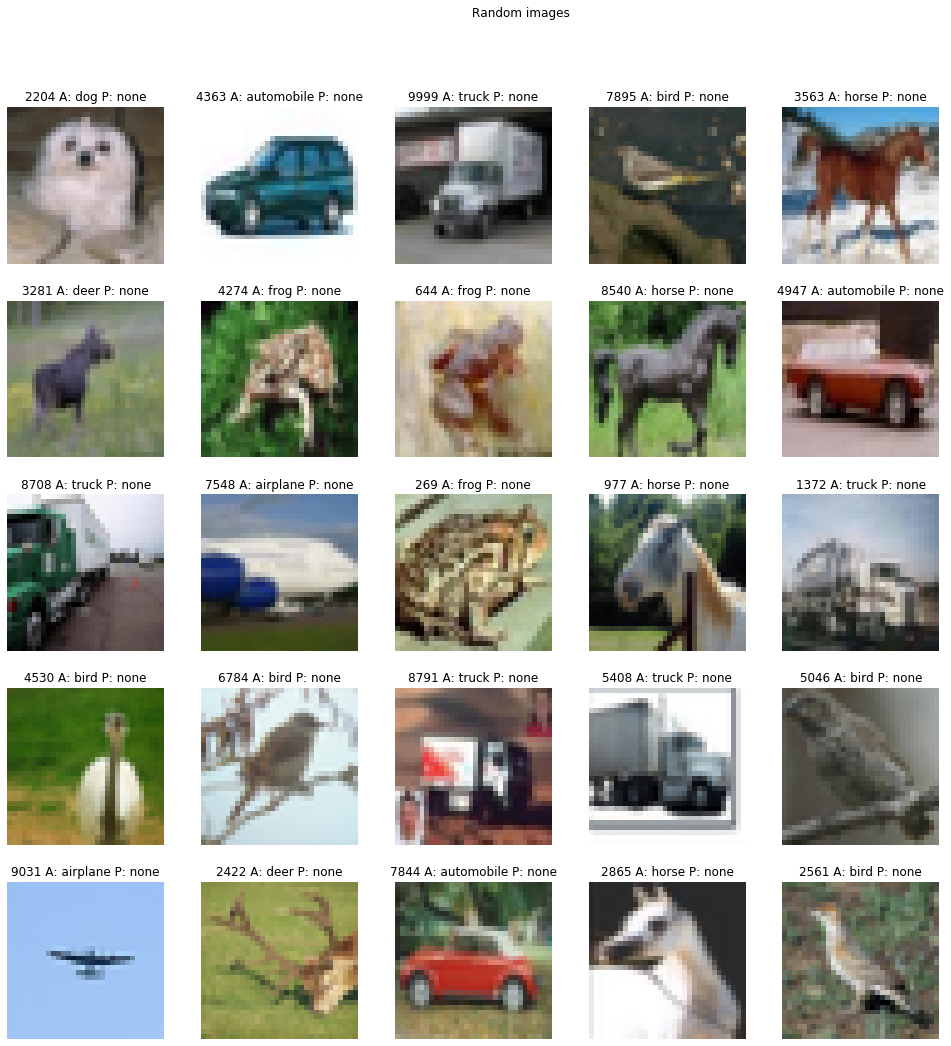

In [15]:
plot_image(5, 5, X, Y)

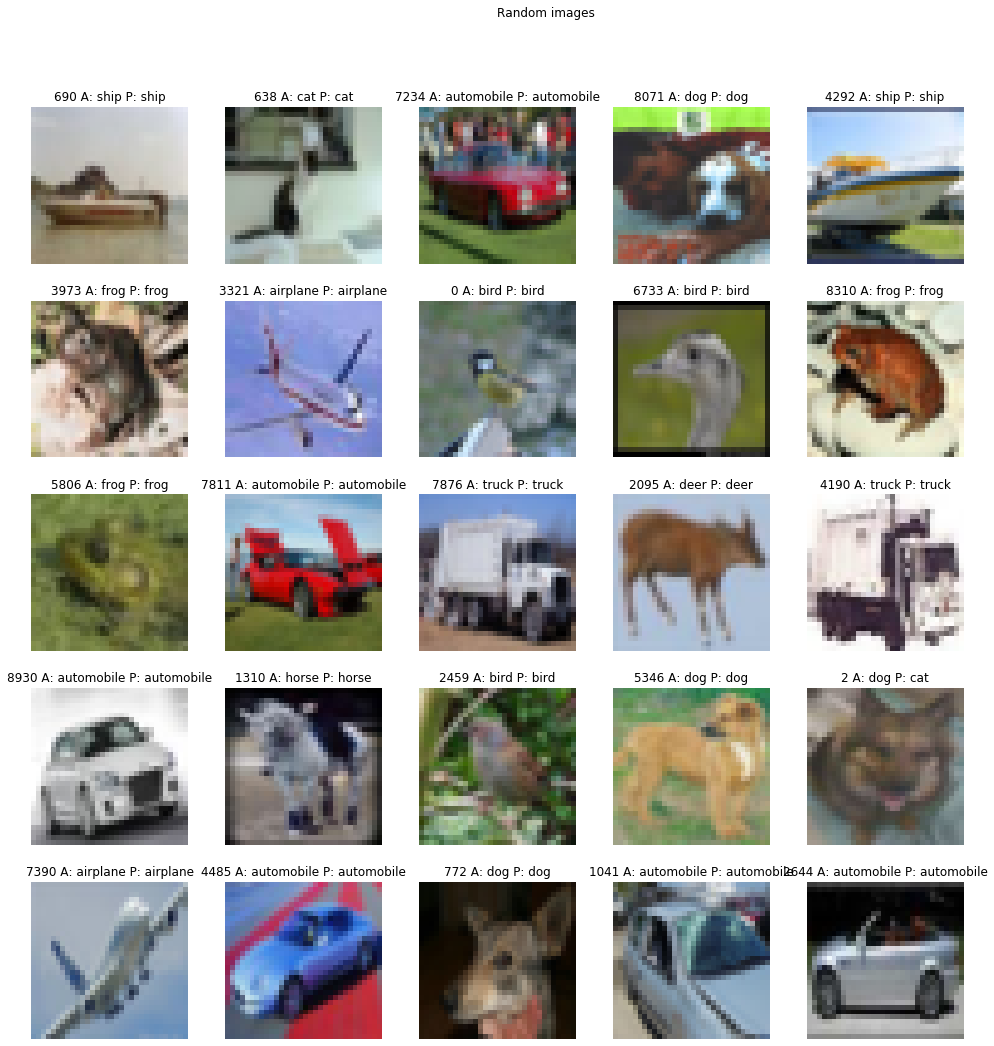

In [16]:
plot_image(5, 5, X, Y, results)

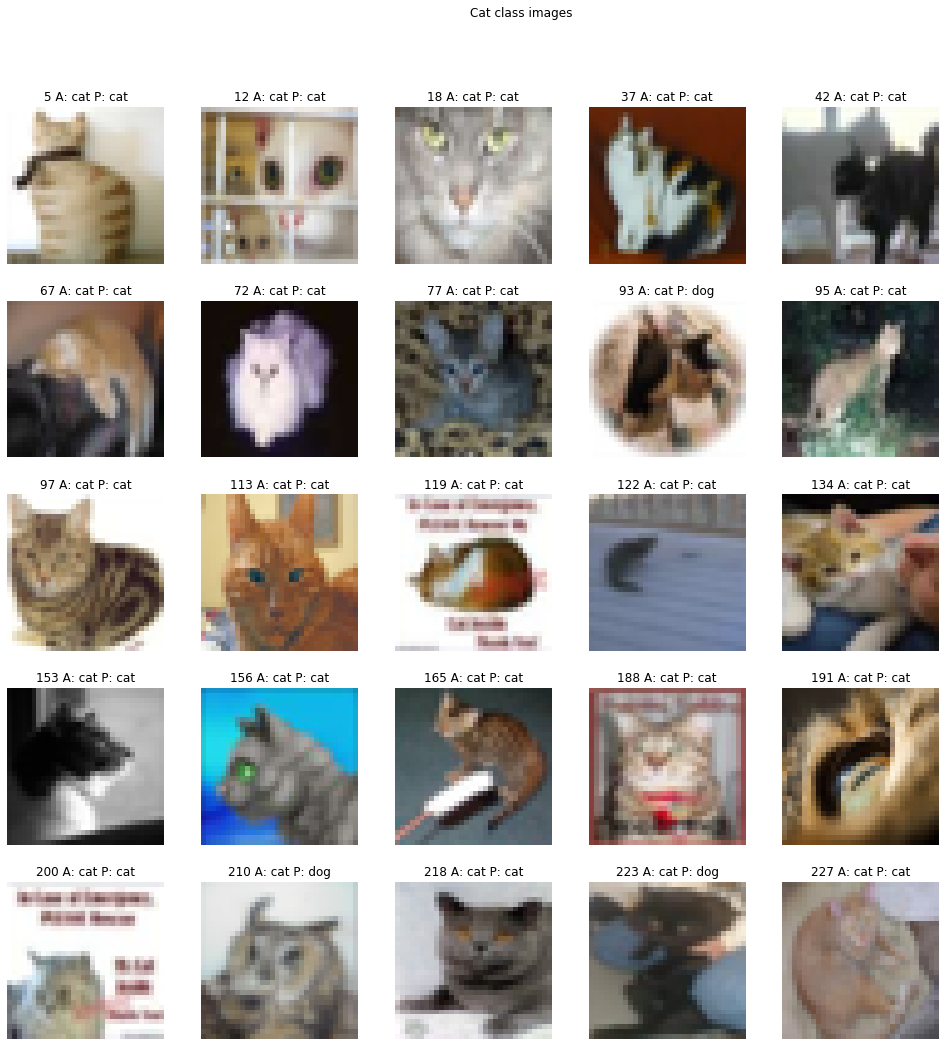

In [17]:
plot_image(5, 5, X, Y, results, ptype='class', pclass=3)

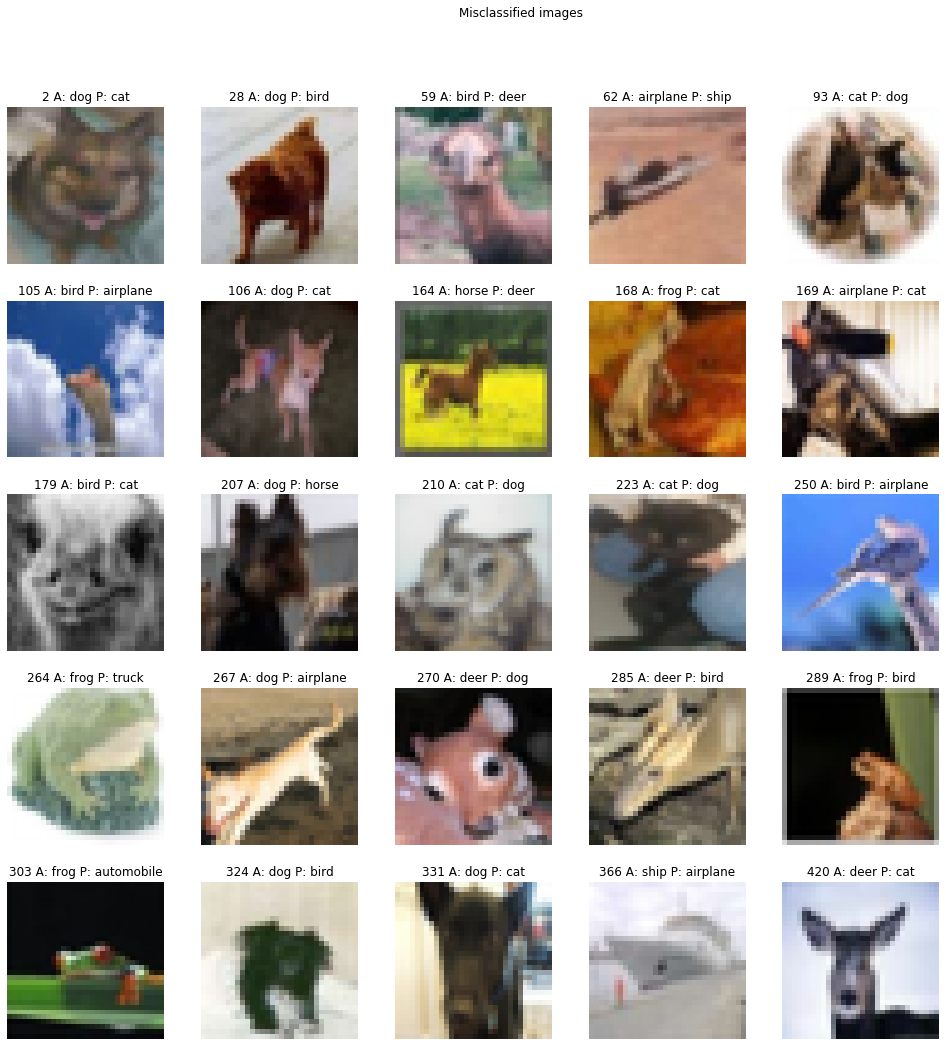

In [18]:
plot_image(5, 5, X, Y, results, ptype='missed')

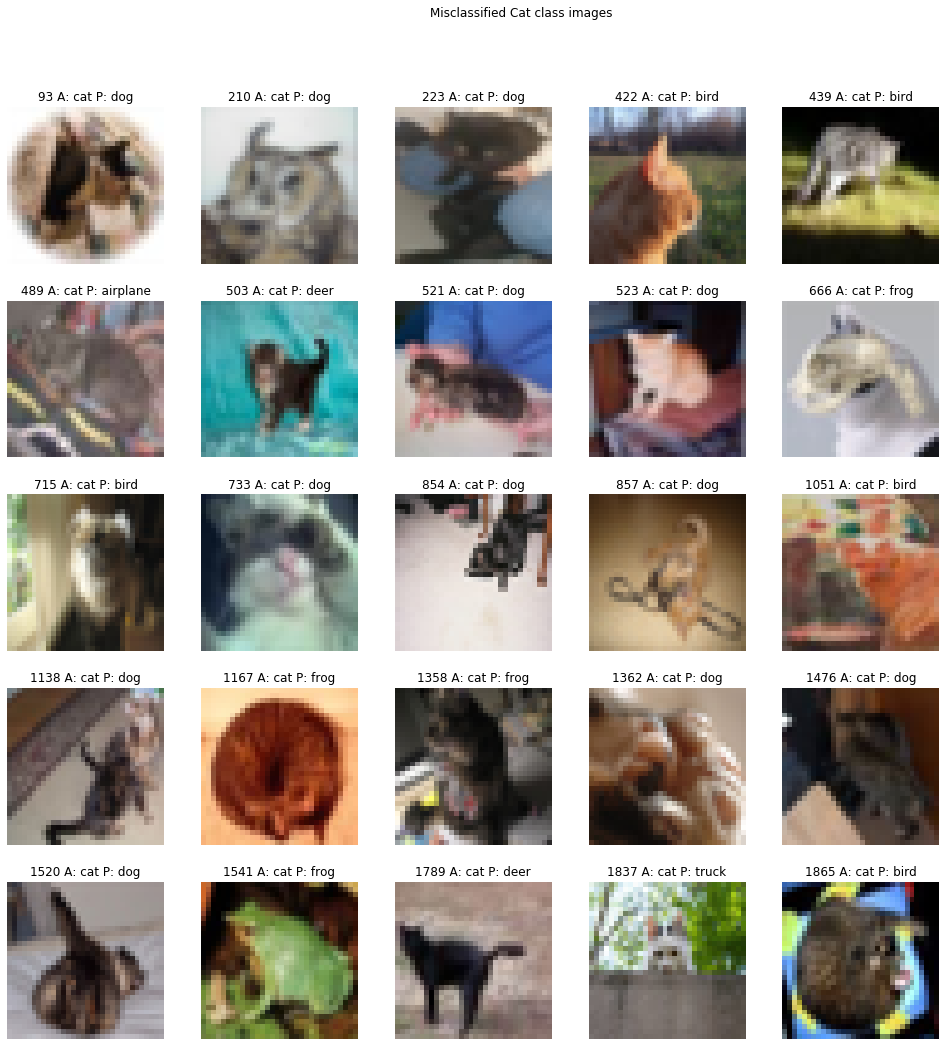

In [19]:
plot_image(5, 5, X, Y, results, ptype='missed', pclass=3)

